<a href="https://colab.research.google.com/github/sushirito/ArsenicFR/blob/main/DeepXDE_PINNRobustIntegration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install deepxde

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.2/194.2 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 10.9 MB/s eta 0:00:00


In [2]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


DeepXDE 1.14.0
Data OK: 601 points
Compiling model...
Building feed-forward neural network...
'build' took 0.060776 s

'compile' took 1.305810 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [6.40e-16, 8.40e-17, 5.22e-01]    [5.94e-16, 7.95e-17, 5.22e-01]    []  
Epoch 1: train loss improved from inf to 5.22e-01, saving model to /content/pinn_eps_ckpt_pinn/held_10_seed_1337/best-1.ckpt ...

500       [3.94e-19, 6.93e-20, 2.50e-05]    [3.90e-19, 1.26e-19, 2.50e-05]    []  
Epoch 500: train loss improved from 5.22e-01 to 2.50e-05, saving model to /content/pinn_eps_ckpt_pinn/held_10_seed_1337/best-500.ckpt ...

1000      [1.22e-19, 2.57e-20, 6.01e-06]    [1.30e-19, 5.07e-20, 6.01e-06]    []  
Epoch 1000: train loss improved from 2.50e-05 to 6.01e-06, saving model to /content/pinn_eps_ckpt_pinn/held_10_seed_1337/best-1000.ckpt ...

1500      [6.97e-20, 1.42e-20, 2.36e-06]    [8.02e-20, 2.99e-20, 2.36e-06]    []  
Epo

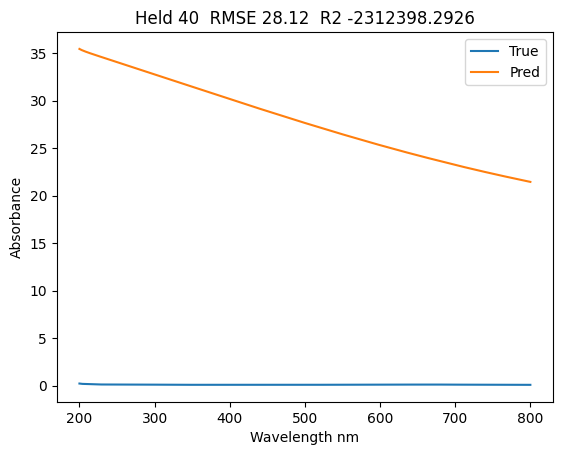

Compiling model...
Building feed-forward neural network...
'build' took 0.074812 s

'compile' took 3.833561 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [5.68e-16, 7.99e-17, 5.19e-01]    [5.69e-16, 7.95e-17, 5.19e-01]    []  
500       [4.52e-19, 4.42e-20, 2.54e-05]    [3.77e-19, 4.41e-20, 2.54e-05]    []  
1000      [1.52e-19, 1.69e-20, 6.00e-06]    [1.42e-19, 1.69e-20, 6.00e-06]    []  

Best model at step 1000:
  train loss: 6.00e-06
  test loss: 6.00e-06
  test metric: []

'train' took 14.726135 s

Compiling model...
'compile' took 2.484717 s

Training model...

Step      Train loss                        Test loss                         Test metric
1000      [1.52e-19, 1.69e-20, 6.00e-06]    [1.42e-19, 1.69e-20, 6.00e-06]    []  
1017      [1.52e-19, 1.69e-20, 6.00e-06]    [1.42e-19, 1.69e-20, 6.00e-06]    []  

Best model at step 1000:
  train loss: 6.00e-06
  test loss: 6.00e-06
  test metric: []

'tra

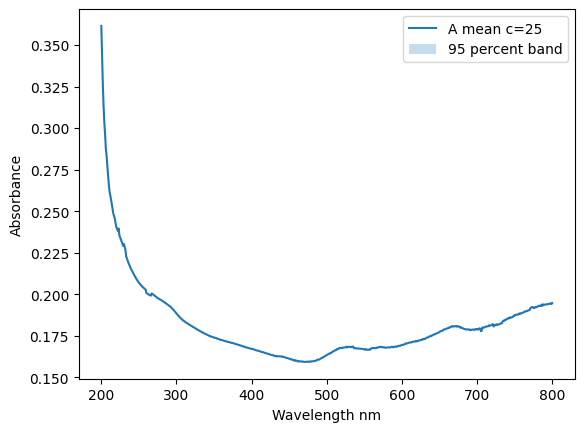

Wrote /content/A_pred_c25_ensemble_PINN.csv


In [6]:
# ===== PINN UV-Vis with DeepXDE: end-to-end notebook (robust) =====

# If Colab: first run the next line once to install compatible versions
# !pip -q install deepxde==1.11.0 tensorflow==2.15.1

import os, random, warnings, glob
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import tensorflow as tf
import deepxde as dde
import matplotlib.pyplot as plt

# Reproducibility
def set_seed(seed=1337):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seed(1337)
print("DeepXDE", dde.__version__)

# ===== Paths and constants =====
# Prefer your Drive path; fall back to /content if present there
DATA_PATH_PRIMARY = "/content/drive/MyDrive/ArsenicSTS/UVVisData/0.30MB_AuNP_As.csv"
DATA_PATH_FALLBACK = "/content/0.30MB_AuNP_As.csv"
DATA_PATH = DATA_PATH_PRIMARY if os.path.exists(DATA_PATH_PRIMARY) else DATA_PATH_FALLBACK

REQUIRED_COLS = ["Wavelength","0","10","20","30","40","60"]
C_LEVELS = [0,10,20,30,40,60]
B_PATHLEN_CM = 1.0

_LAM_MIN, _LAM_MAX = 200.0, 800.0
_C_MIN, _C_MAX = 0.0, 60.0
_dlam_dlamhat = (_LAM_MAX - _LAM_MIN) / 2.0
_dc_dchat = (_C_MAX - _C_MIN) / 2.0

# ===== Phase 1: Data loading and preprocessing =====
def load_uvvis_csv(path: str) -> pd.DataFrame:
    if not os.path.exists(path):
        raise FileNotFoundError(f"Missing CSV at {path}")
    df = pd.read_csv(path)
    missing = [c for c in REQUIRED_COLS if c not in df.columns]
    if missing:
        raise ValueError(f"CSV missing required columns: {missing}")
    if len(df) != 601:
        raise ValueError(f"Expected 601 wavelength points. Got {len(df)}")
    return df

def preprocess(df: pd.DataFrame):
    df_sorted = df.sort_values("Wavelength", ascending=True).reset_index(drop=True)
    wl = df_sorted["Wavelength"].to_numpy().astype(np.float32)

    A_bg = df_sorted["0"].to_numpy().astype(np.float32)
    deltas = {}
    for c in C_LEVELS:
        A = df_sorted[str(c)].to_numpy().astype(np.float32)
        deltas[c] = (A - A_bg).astype(np.float32)

    wl_norm = 2.0 * (wl - _LAM_MIN) / (_LAM_MAX - _LAM_MIN) - 1.0
    return dict(wl=wl, wl_norm=wl_norm.astype(np.float32), A_bg=A_bg, deltas=deltas)

df = load_uvvis_csv(DATA_PATH)
prep = preprocess(df)
print("Data OK:", len(prep["wl"]), "points")

# ===== Phase 2: Network definition (epsilon_net) =====
def create_epsilon_net(hidden=3, width=64):
    layer_sizes = [2] + [width]*hidden + [1]
    net = dde.nn.FNN(layer_sizes, "tanh", "Glorot uniform")
    def output_transform(x, y):  # enforce epsilon >= 0
        return tf.nn.softplus(y)
    net.apply_output_transform(output_transform)
    return net

# ===== Phase 3: PINN residuals (physics + smoothness) =====
def pinn_pde_residual(x, y):
    c_hat = x[:, 1:2]
    c = 0.5 * (c_hat + 1.0) * (_C_MAX - _C_MIN) + _C_MIN

    eps = y
    deltaA = B_PATHLEN_CM * c * eps

    dDeltaA_dc_hat = dde.grad.jacobian(deltaA, x, i=0, j=1)
    dDeltaA_dc = dDeltaA_dc_hat / _dc_dchat

    deps_dc_hat = dde.grad.jacobian(eps, x, i=0, j=1)
    eps_c = deps_dc_hat / _dc_dchat

    r_phys = dDeltaA_dc - (B_PATHLEN_CM * (eps + c * eps_c))  # shape (N,1)

    d2eps_dlamhat2 = dde.grad.hessian(eps, x, i=0, j=0)
    eps_lamlam = d2eps_dlamhat2 / (_dlam_dlamhat ** 2)
    r_smooth = eps_lamlam  # shape (N,1)

    # Return a list so DeepXDE counts two separate PDE losses
    return [r_phys, r_smooth]


# ===== Helpers: supervised labels as epsilon and dataset builder =====
def make_eps_targets(prep, c_values=(10,20,30,40,60), b_cm=1.0, debug=False):
    wl_norm = np.asarray(prep["wl_norm"], dtype=np.float32)
    assert wl_norm.ndim == 1 and wl_norm.shape[0] == 601, f"wl_norm bad shape: {wl_norm.shape}"
    wl_hat = wl_norm.reshape(-1, 1)

    X_list, eps_list = [], []
    if debug:
        print("make_eps_targets: c_values =", list(c_values))

    for c in c_values:
        c_raw = float(c)
        assert c_raw > 0.0, f"c must be > 0 for epsilon labels, got {c}"
        n = wl_hat.shape[0]
        c_hat = 2.0 * (c_raw - _C_MIN) / (_C_MAX - _C_MIN) - 1.0
        c_col = np.full((n, 1), c_hat, dtype=np.float32)

        Xc = np.hstack([wl_hat, c_col]).astype(np.float32)
        assert Xc.shape == (n, 2), f"Xc bad shape for c={c}: {Xc.shape}"

        delta = np.asarray(prep["deltas"][c], dtype=np.float32).reshape(-1, 1)
        assert delta.shape == (n, 1), f"delta bad shape for c={c}: {delta.shape}"

        eps = (delta / (b_cm * c_raw)).astype(np.float32)
        assert eps.shape == (n, 1), f"eps bad shape for c={c}: {eps.shape}"

        if debug:
            print(f"  c={c}: Xc {Xc.shape}, eps {eps.shape}, finite={np.isfinite(eps).all()}")

        X_list.append(Xc)
        eps_list.append(eps)

    assert len(X_list) > 0 and len(eps_list) > 0, "No training blocks were built"

    for i, Xi in enumerate(X_list):
        assert Xi.shape[1] == 2, f"X_list[{i}] has {Xi.shape[1]} cols"
    for i, Yi in enumerate(eps_list):
        assert Yi.shape[1] == 1, f"eps_list[{i}] has {Yi.shape[1]} cols"

    X = np.concatenate(X_list, axis=0).astype(np.float32)
    eps_y = np.concatenate(eps_list, axis=0).astype(np.float32)

    assert X.ndim == 2 and X.shape[1] == 2, f"Final X bad shape: {X.shape}"
    assert eps_y.ndim == 2 and eps_y.shape[1] == 1 and eps_y.shape[0] == X.shape[0], f"Final eps_y bad shape: {eps_y.shape}"
    return X, eps_y

def build_pinn_dataset(prep, held=None, debug=False):
    all_cs = [10,20,30,40,60]
    train_cs = all_cs if held is None else [c for c in all_cs if c != held]
    if debug:
        print("build_pinn_dataset:", "held =", held, "train_cs =", train_cs)

    X_train, y_train = make_eps_targets(prep, c_values=train_cs, b_cm=B_PATHLEN_CM, debug=debug)

    test_cs  = [] if held is None else [held]
    if test_cs:
        X_test, y_test = make_eps_targets(prep, c_values=test_cs, b_cm=B_PATHLEN_CM, debug=debug)
    else:
        X_test, y_test = X_train[:512], y_train[:512]

    geom = dde.geometry.Rectangle(xmin=[-1.0, -1.0], xmax=[1.0, 1.0])
    bc_data = dde.icbc.PointSetBC(X_train, y_train)

    data = dde.data.PDE(
        geom,
        pinn_pde_residual,
        bcs=[bc_data],
        num_domain=0,
        num_boundary=0,
        anchors=X_train,  # evaluate residuals exactly on training inputs
        num_test=max(1, X_train.shape[0] // 10),
    )
    return data, (X_test, y_test)

# ===== Phase 4: Training with Adam then L-BFGS, checkpoints, LOSO CV =====
def train_once_pinn_ckpt(
    prep,
    held=None,
    seed=1337,
    adam_iters=3000,
    lr=1e-3,
    bfgs=True,
    w_phys=0.1,
    w_smooth=1e-4,
    ckpt_dir="/content/pinn_eps_ckpt_pinn",
    debug=False,
):
    set_seed(seed)
    data, (X_test, y_test) = build_pinn_dataset(prep, held=held, debug=debug)
    net = create_epsilon_net()
    model = dde.Model(data, net)

    ckpt_path = os.path.join(ckpt_dir, f"held_{held or 'all'}_seed_{seed}")
    os.makedirs(ckpt_path, exist_ok=True)
    cb_ckpt = dde.callbacks.ModelCheckpoint(
        os.path.join(ckpt_path, "best"),
        save_better_only=True,
        period=1,
        verbose=True,
    )
    cb_early = dde.callbacks.EarlyStopping(min_delta=1e-6, patience=800)

    # Loss order: [r_phys, r_smooth, PointSetBC]
    loss_weights = [w_phys, w_smooth, 1.0]

    model.compile("adam", lr=lr, loss_weights=loss_weights)
    losshistory, train_state = model.train(
        iterations=adam_iters, display_every=500, callbacks=[cb_ckpt, cb_early]
    )

    if bfgs:
        model.compile("L-BFGS", loss_weights=loss_weights)
        losshistory, train_state = model.train(display_every=100, callbacks=[cb_ckpt])

    model.save(os.path.join(ckpt_path, "final"))

    # Test MSE in epsilon space
    y_pred = model.predict(X_test)
    mse_eps = float(np.mean((y_pred - y_test) ** 2))
    return model, losshistory, train_state, mse_eps, ckpt_path

def run_loso_cv_pinn(prep, adam_iters=2000, lr=1e-3, bfgs=True, w_phys=0.1, w_smooth=1e-4, debug=False):
    results = {}
    for held in [10, 20, 30, 40, 60]:
        model, _, _, mse_eps, ckpt = train_once_pinn_ckpt(
            prep, held=held, adam_iters=adam_iters, lr=lr, bfgs=bfgs,
            w_phys=w_phys, w_smooth=w_smooth, debug=debug
        )
        results[held] = {"mse_eps": mse_eps, "ckpt": ckpt}
        print(f"Held {held}  MSE_eps={mse_eps:.4e}  ckpt={ckpt}")
    return results

cv_results = run_loso_cv_pinn(prep, adam_iters=2000, lr=1e-3, bfgs=True, w_phys=0.1, w_smooth=1e-4, debug=False)
cv_results

# ===== Phase 5: Prediction, uncertainty, CSV =====
def predict_absorbance_for_c(model, prep, c):
    wl = prep["wl"]; A_bg = prep["A_bg"]
    wl_hat = prep["wl_norm"].reshape(-1, 1)
    c_hat = 2.0 * (float(c) - _C_MIN) / (_C_MAX - _C_MIN) - 1.0
    X = np.hstack([wl_hat, np.full_like(wl_hat, c_hat, dtype=np.float32)])
    eps = model.predict(X).reshape(-1)
    A_pred = A_bg + B_PATHLEN_CM * float(c) * eps
    return wl, A_pred

def evaluate_absorbance_metrics(A_true, A_pred):
    rmse = float(np.sqrt(np.mean((A_pred - A_true) ** 2)))
    mae  = float(np.mean(np.abs(A_pred - A_true)))
    ss_res = float(np.sum((A_true - A_pred) ** 2))
    ss_tot = float(np.sum((A_true - np.mean(A_true)) ** 2))
    r2 = float(1.0 - ss_res / ss_tot) if ss_tot > 0 else np.nan
    return {"rmse": rmse, "mae": mae, "r2": r2}

def plot_absorbance(wl, A_true, A_pred, title="Prediction"):
    plt.figure()
    if A_true is not None:
        plt.plot(wl, A_true, label="True")
    plt.plot(wl, A_pred, label="Pred")
    plt.xlabel("Wavelength nm"); plt.ylabel("Absorbance")
    plt.title(title); plt.legend(); plt.show()

def export_prediction_csv(path, wl, A, A_lo=None, A_hi=None):
    df = pd.DataFrame({"wavelength_nm": wl, "A": A})
    if A_lo is not None and A_hi is not None:
        df["A_lo"] = A_lo; df["A_hi"] = A_hi
    df.to_csv(path, index=False)
    print("Wrote", path)

def restore_fold_model(prep, held, ckpt, w_phys=0.1, w_smooth=1e-4):
    data, _ = build_pinn_dataset(prep, held=held)
    model = dde.Model(data, create_epsilon_net())
    model.compile("adam", lr=1e-3, loss_weights=[w_phys, w_smooth, 1.0])
    for candidate in ["best", "final"]:
        p = os.path.join(ckpt, candidate)
        try:
            model.restore(p)
            print("Restored from:", p)
            return model
        except Exception as e:
            print("Restore failed at", p, "->", e)
    print("No checkpoint found. Initializing with a tiny train step.")
    model.train(iterations=1, display_every=1)
    print("CKPT contents:", glob.glob(os.path.join(ckpt, "*")))
    return model

# Demo: evaluate a held fold in absorbance space
held = 40
model_held = restore_fold_model(prep, held, cv_results[held]["ckpt"], w_phys=0.1, w_smooth=1e-4)
wl, A_pred = predict_absorbance_for_c(model_held, prep, held)
A_true = prep["A_bg"] + prep["deltas"][held]
metrics = evaluate_absorbance_metrics(A_true, A_pred)
print("Held metrics:", metrics)
plot_absorbance(wl, A_true, A_pred, title=f"Held {held}  RMSE {metrics['rmse']:.4g}  R2 {metrics['r2']:.4f}")

# Ensemble uncertainty for unseen concentration using full-data training each time
def train_full_pinn(prep, seed=1337, adam_iters=1500, lr=1e-3, bfgs=True, w_phys=0.1, w_smooth=1e-4):
    set_seed(seed)
    data, _ = build_pinn_dataset(prep, held=None)
    model = dde.Model(data, create_epsilon_net())
    model.compile("adam", lr=lr, loss_weights=[w_phys, w_smooth, 1.0])
    model.train(iterations=adam_iters, display_every=500)
    if bfgs:
        model.compile("L-BFGS", loss_weights=[w_phys, w_smooth, 1.0])
        model.train(display_every=100)
    return model

def ensemble_absorbance(prep, c_new, seeds=(11,22,33), adam_iters=1200, lr=1e-3, w_phys=0.1, w_smooth=1e-4):
    wl = prep["wl"]; A_bg = prep["A_bg"]
    wl_hat = prep["wl_norm"].reshape(-1, 1)
    c_hat = 2.0 * (float(c_new) - _C_MIN) / (_C_MAX - _C_MIN) - 1.0
    X = np.hstack([wl_hat, np.full_like(wl_hat, c_hat, dtype=np.float32)])

    A_list = []
    for s in seeds:
        m = train_full_pinn(prep, seed=s, adam_iters=adam_iters, lr=lr, bfgs=True, w_phys=w_phys, w_smooth=w_smooth)
        eps = m.predict(X).reshape(-1)
        A = A_bg + B_PATHLEN_CM * float(c_new) * eps
        A_list.append(A)
    A_stack = np.stack(A_list, axis=0)
    A_mean, A_std = A_stack.mean(axis=0), A_stack.std(axis=0)
    return wl, A_mean, A_std

wl, A_mean, A_std = ensemble_absorbance(prep, c_new=25, seeds=(101,202,303), adam_iters=1000, w_phys=0.1, w_smooth=1e-4)
plt.figure()
plt.plot(wl, A_mean, label="A mean c=25")
plt.fill_between(wl, A_mean - 2*A_std, A_mean + 2*A_std, alpha=0.25, label="95 percent band")
plt.xlabel("Wavelength nm"); plt.ylabel("Absorbance"); plt.legend(); plt.show()

export_prediction_csv("/content/A_pred_c25_ensemble_PINN.csv", wl, A_mean, A_mean - 2*A_std, A_mean + 2*A_std)


Compiling model...
Building feed-forward neural network...
'build' took 0.105019 s

'compile' took 1.704931 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [6.25e-16, 8.01e-17, 5.20e-01]    [5.94e-16, 7.95e-17, 5.20e-01]    []  
Epoch 1: train loss improved from inf to 5.20e-01, saving model to /content/pinn_eps_ckpt_pinn/held_20_seed_1337/best-1.ckpt ...

500       [4.32e-19, 5.89e-20, 2.27e-05]    [4.62e-19, 6.50e-20, 2.27e-05]    []  
Epoch 500: train loss improved from 5.20e-01 to 2.27e-05, saving model to /content/pinn_eps_ckpt_pinn/held_20_seed_1337/best-500.ckpt ...

1000      [1.40e-19, 2.22e-20, 5.05e-06]    [1.13e-19, 2.47e-20, 5.05e-06]    []  
Epoch 1000: train loss improved from 2.27e-05 to 5.05e-06, saving model to /content/pinn_eps_ckpt_pinn/held_20_seed_1337/best-1000.ckpt ...

1500      [6.87e-20, 1.26e-20, 1.88e-06]    [6.02e-20, 1.43e-20, 1.88e-06]    []  
Epoch 1500: train loss improved from 5

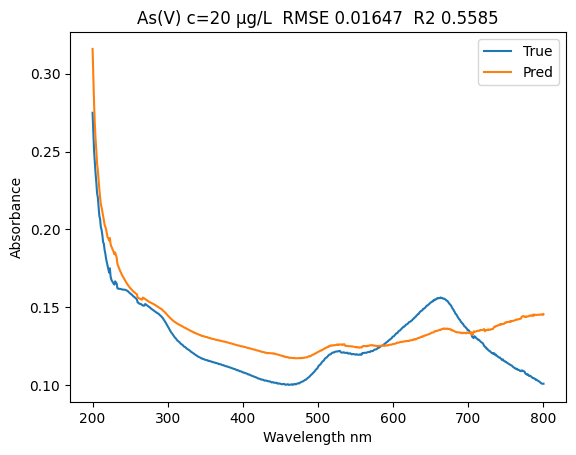

In [8]:
# Retrain LOSO with c=20 held out, then predict and plot for c=20
model_20, _, _, mse_eps_20, ckpt_20 = train_once_pinn_ckpt(
    prep, held=20, adam_iters=2000, lr=1e-3, bfgs=True, w_phys=0.1, w_smooth=1e-4
)
wl, A_pred_20 = predict_absorbance_for_c(model_20, prep, 20)
A_true_20 = prep["A_bg"] + prep["deltas"][20]
metrics_20 = evaluate_absorbance_metrics(A_true_20, A_pred_20)
print("epsilon-space MSE (held 20):", mse_eps_20, "| absorbance metrics:", metrics_20)
plot_absorbance(wl, A_true_20, A_pred_20,
                title=f"As(V) c=20 µg/L  RMSE {metrics_20['rmse']:.4g}  R2 {metrics_20['r2']:.4f}")


In [4]:
# ===== PINN PDE Shootout: control vs c-ODE vs drift-diffusion-kinetics =====
import os, numpy as np, tensorflow as tf, deepxde as dde

# --- Shared backbone: A(λ,c) ---
def make_backbone(hidden=3, width=64):
    net = dde.nn.FNN([2] + [width]*hidden + [1], "tanh", "Glorot uniform")
    net.apply_output_transform(lambda x, y: tf.nn.softplus(y))  # A >= 0
    return net

# --- Coefficient nets that depend only on λ ---
def _coef_net(width=32):
    n = dde.nn.FNN([1, width, width, 1], "tanh", "Glorot uniform")
    n.apply_output_transform(lambda x, y: tf.nn.softplus(y))  # nonneg where needed
    return n

k_net     = _coef_net()
gamma_net = _coef_net()
v_net     = _coef_net()
D_net     = _coef_net()

# --- Helpers for scaling back from normalized inputs ---
def lam_from_hat(lam_hat):
    return 0.5*(lam_hat+1.0)*(_LAM_MAX-_LAM_MIN)+_LAM_MIN

def c_from_hat(c_hat):
    return 0.5*(c_hat+1.0)*(_C_MAX-_C_MIN)+_C_MIN

# --- Residuals registry ---
def residual_control(x, y):
    # No PDE constraint. Return zeros so only PointSetBC is active.
    return tf.zeros_like(y)

def residual_c_ode(x, y):
    lam_hat = x[:, 0:1]
    # A(λ,c) is y
    dA_dc_hat = dde.grad.jacobian(y, x, i=0, j=1)
    dA_dc = dA_dc_hat / _dc_dchat
    k     = k_net(lam_hat)
    gamma = gamma_net(lam_hat)
    return dA_dc - k + gamma*y

def residual_ddk(x, y):
    lam_hat = x[:, 0:1]
    # Derivatives
    dA_dc_hat  = dde.grad.jacobian(y, x, i=0, j=1)
    dA_dc      = dA_dc_hat / _dc_dchat
    dA_dlamhat = dde.grad.jacobian(y, x, i=0, j=0)
    dA_dlam    = dA_dlamhat / _dlam_dlamhat
    d2A_dlam2  = dde.grad.hessian(y, x, i=0, j=0) / (_dlam_dlamhat**2)
    # Coeffs
    k     = k_net(lam_hat)
    gamma = gamma_net(lam_hat)
    v     = v_net(lam_hat)
    D     = D_net(lam_hat)
    # PDE: ∂A/∂c - k + γ A - v ∂A/∂λ - D ∂²A/∂λ² = 0
    return dA_dc - k + gamma*y - v*dA_dlam - D*d2A_dlam2

PDES = {
    "control": residual_control,
    "c_ode": residual_c_ode,
    "ddk": residual_ddk,  # drift-diffusion-kinetics
}

# --- Data builder using your existing 'prep' dict ---
def build_A_targets(prep, c_values):
    wl = prep["wl"].astype(np.float32)
    wl_hat = prep["wl_norm"].reshape(-1, 1).astype(np.float32)
    X_list, A_list = [], []
    for c in c_values:
        A = (prep["A_bg"] + prep["deltas"][c]).astype(np.float32).reshape(-1, 1)
        c_hat = 2.0*(float(c)-_C_MIN)/(_C_MAX-_C_MIN) - 1.0
        Xc = np.hstack([wl_hat, np.full_like(wl_hat, c_hat, dtype=np.float32)])
        X_list.append(Xc); A_list.append(A)
    X = np.vstack(X_list).astype(np.float32)
    Y = np.vstack(A_list).astype(np.float32)
    return X, Y

def build_dataset_for_residual(prep, residual_fn, held):
    train_cs = [c for c in [10,20,30,40,60] if c != held]
    X_train, y_train = build_A_targets(prep, train_cs)
    X_test,  y_test  = build_A_targets(prep, [held])

    geom = dde.geometry.Rectangle(xmin=[-1.0, -1.0], xmax=[1.0, 1.0])
    bc   = dde.icbc.PointSetBC(X_train, y_train)
    data = dde.data.PDE(
        geom,
        residual_fn,
        bcs=[bc],
        num_domain=0,
        num_boundary=0,
        anchors=X_train,
        num_test=max(1, X_train.shape[0]//10),
    )
    return data, (X_test, y_test)

# --- Training for one run ---
def train_once(residual_fn, held, seed=1337, adam_iters=1500, lr=1e-3, w_pde=0.1):
    set_seed(seed)
    data, (X_test, y_test) = build_dataset_for_residual(prep, residual_fn, held)
    net = make_backbone()
    model = dde.Model(data, net)
    model.compile("adam", lr=lr, loss_weights=[w_pde, 1.0])  # [PDE, PointSetBC]
    model.train(iterations=adam_iters, display_every=500)
    model.compile("L-BFGS", loss_weights=[w_pde, 1.0])
    model.train(display_every=100)
    y_pred = model.predict(X_test)
    return model, y_test, y_pred

# --- Metrics: RMSE and peak location error in 580-740 nm band ---
def metrics_for_run(y_true, y_pred, held):
    wl = prep["wl"]
    band = (wl >= 580) & (wl <= 740)
    A_true = y_true.reshape(-1, 601)
    A_pred = y_pred.reshape(-1, 601)
    # Only one concentration in test set, so index 0
    A_true_1 = A_true[0]; A_pred_1 = A_pred[0]
    rmse = float(np.sqrt(np.mean((A_pred_1 - A_true_1)**2)))
    # Peak nm in band
    idx_t = np.argmax(A_true_1[band]); idx_p = np.argmax(A_pred_1[band])
    lam_band = wl[band]
    peak_err_nm = float(abs(lam_band[idx_p] - lam_band[idx_t]))
    return {"rmse": rmse, "peak_err_nm": peak_err_nm}

# --- Shootout harness ---
def run_shootout(prep, seeds=(101,202,303), adam_iters=1500, w_pde=0.1):
    results = []
    for name, res_fn in PDES.items():
        for held in [10,20,30,40,60]:
            for s in seeds:
                model, yt, yp = train_once(res_fn, held, seed=s, adam_iters=adam_iters, w_pde=w_pde)
                m = metrics_for_run(yt, yp, held)
                results.append({"pde": name, "held": held, "seed": s, **m})
                print(f"{name:8s} held={held:2d} seed={s:3d}  RMSE={m['rmse']:.4e}  PeakErr={m['peak_err_nm']:.1f}")
    # Aggregate
    import pandas as pd
    df = pd.DataFrame(results)
    summary = df.groupby("pde")[["rmse","peak_err_nm"]].mean().sort_values("rmse")
    print("\nMean over folds and seeds:")
    print(summary)
    return df, summary

# Run it
shootout_df, shootout_summary = run_shootout(prep, seeds=(101,202,303), adam_iters=1200, w_pde=0.1)

Compiling model...
Building feed-forward neural network...
'build' took 0.060403 s

'compile' took 0.478424 s

Training model...

Step      Train loss              Test loss               Test metric
0         [0.00e+00, 3.72e-01]    [0.00e+00, 3.72e-01]    []  
500       [0.00e+00, 3.56e-04]    [0.00e+00, 3.56e-04]    []  
1000      [0.00e+00, 1.91e-04]    [0.00e+00, 1.91e-04]    []  
1200      [0.00e+00, 1.12e-04]    [0.00e+00, 1.12e-04]    []  

Best model at step 1200:
  train loss: 1.12e-04
  test loss: 1.12e-04
  test metric: []

'train' took 5.149592 s

Compiling model...
'compile' took 0.498164 s

Training model...

Step      Train loss              Test loss               Test metric
1200      [0.00e+00, 1.12e-04]    [0.00e+00, 1.12e-04]    []  
1217      [0.00e+00, 1.12e-04]    [0.00e+00, 1.12e-04]    []  

Best model at step 1200:
  train loss: 1.12e-04
  test loss: 1.12e-04
  test metric: []

'train' took 3.827933 s

control  held=10 seed=101  RMSE=2.0647e-02  PeakErr=74.0


TypeError: 'FNN' object is not callable